In [ ]:
import os, time, librosa, librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam

import audio_data_loader as audioloader
import audio_data_writer as audiowriter
import dataset_loader as dataset
import references as ref

### Neural network model builder



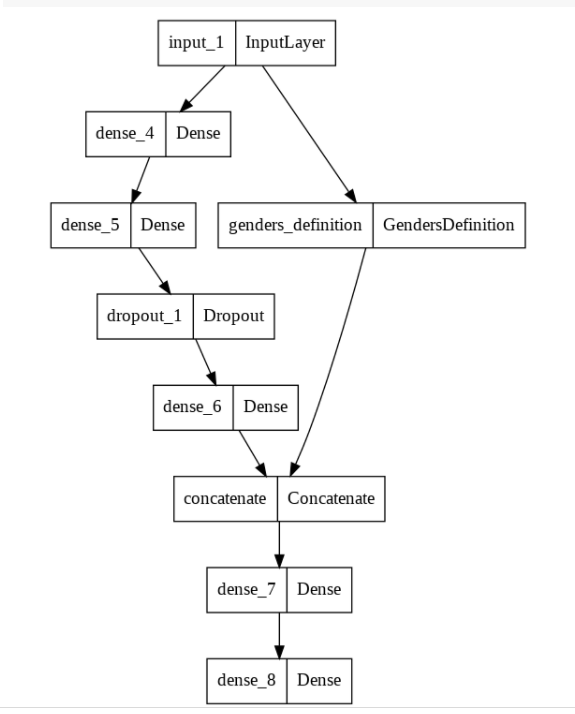

In [ ]:
class GendersDefinition(Model):
    
    def __init__(self, audio_shape):
        super(GendersDefinition, self).__init__()
        
        self.layer_input = Input((audio_shape, 1))
        self.flatten = Flatten()
        self.layer_001 = Dense(400, activation = 'relu')
        self.layer_002 = Dense(320, activation = 'relu')
        self.layer_003 = Dropout(0.2)
        self.layer_004 = Dense(100, activation = 'relu')
        self.layer_output = Dense(1, activation = 'sigmoid')
        
    def call(self, inputs):
        #x = self.layer_input(inputs)
        x = self.layer_001(inputs)
        x = self.flatten(x)
        x = self.layer_002(x)
        x = self.layer_003(x)
        x = self.layer_004(x)
        
        return self.layer_output(x)

In [ ]:
def get_model(audio_shape, g_model):
    
    g_model.trainable = False
    
    # emotion part
    emotion_input = Input((audio_shape, 1))
    
    x = Conv1D(64, 3, activation='relu')(emotion_input)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    
    # gender part
    z = g_model(emotion_input)
    
    # merge parts    
    concatenate_layer = Concatenate()([x, z])    
    y = Dense(30, activation = 'relu')(concatenate_layer)
    
    # output layer
    output_layer = Dense(9, activation = 'softmax')(y)
    
    model = Model(emotion_input, output_layer)
    
    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

### Visualization

In [ ]:
def show_accuracy(data):
    
    fig, ax = plt.subplots(figsize = (15, 6))
    
    ax.plot(data.epoch, data.history['accuracy'], label = 'Accuracy')
    ax.plot(data.epoch, data.history['val_accuracy'], label = 'Validation Accuracy')
    
    plt.legend()
    plt.show()

### Dataset loading

In [ ]:
source = audioloader.create_source_dataset(ref.root_path)

In [ ]:
x_data = dataset.get_x_data(source)

In [ ]:
y_data = dataset.get_y_emotion_data(source)
g_data = dataset.get_y_gender_data(source)

In [ ]:
x_train, x_val, y_train, y_val, g_train, g_val = dataset.get_data_split(x_data, y_data, g_data)

In [ ]:
x_train = np.expand_dims(x_train, axis = 2)
x_val = np.expand_dims(x_val, axis = 2)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(g_train.shape)
print(g_val.shape)

### Train gender model

In [ ]:
gender_model = GendersDefinition(x_train.shape[1])

In [ ]:
gender_model.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

In [ ]:
history = gender_model.fit(x_train, g_train, batch_size = 50, epochs = 50, validation_split = 0.1)

In [ ]:
gender_prediction = gender_model.evaluate(x_val, g_val)

In [ ]:
show_accuracy(history)

In [ ]:
g_weights = gender_model.weights

In [ ]:
g_weights

### Train emotions neural model

In [ ]:
model = get_model(x_train.shape[1], gender_model)

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, batch_size = 50, epochs = 50, validation_split = 0.1)

In [ ]:
pred = model.evaluate(x_val, y_val)